# 2.5D DC Resistivity Inversion

This tutorial demonstrates DC resistivity inversion with SimPEG. We load normalized voltage data and 2D topography for a synthetic pole-dipole survey. Once loaded, we demonstrate a standard set of steps for recovering a model that characterizing subsurface electrical resistivity using weighted least-squares inversion.

The following items are emphasized in this tutorial:

- Assigning uncertainties to DC resistivity data.
- Designing a suitable mesh based on survey geometry.
- What model parameters we should invert for.
- Defining the inverse problem (data misfit, regularization, optimization).
- Stopping criteria for the inversion.
- Assessing inversion outputs.

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/dcr_inv.png" width="100%" align="center"/>

## Step 0: Importing Modules

Here, we import all of the functionality required to run the notebook for the tutorial exercise. All of the functionality specific to DC resistivity is imported from [SimPEG.electromagnetics.static.resistivity](https://docs.simpeg.xyz/content/api/SimPEG.electromagnetics.static.resistivity.html).
We also import some useful utility functions from [SimPEG.utils](https://docs.simpeg.xyz/content/api/SimPEG.utils.html). To simulate DC resistivity data, we need to define our problem geometry on a numerical grid (or mesh).
To generate the mesh, we used the [discretize](https://discretize.simpeg.xyz/en/main) package.

In [1]:
# SimPEG functionality
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
    apparent_resistivity_from_voltage,
    pseudo_locations,
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc
from SimPEG.utils import model_builder, Counter
from SimPEG import (
    maps,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)

# discretize functionality
from discretize import TreeMesh
from discretize.utils import active_from_xyz

# Basic Python functionality
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import warnings

# Pooch for downloading files from the web
import pooch

warnings.filterwarnings("ignore")

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

C:\Users\devin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Below is a class specifically used for this tutorial. It is not important to spent time reading through the code in this cell.

In [2]:
class SaveInversionProgress(directives.InversionDirective, Counter):
    """
    A custom directive to save items of interest during the course of an inversion
    """

    def initialize(self):
        """
        This is called when we first start running an inversion
        """
        # initialize an empty dictionary for storing results
        self.inversion_results = {
            "iteration": [],
            "beta": [],
            "phi_d": [],
            "phi_m": [],
            "phi_m_small": [],
            "phi_m_smooth_x": [],
            "phi_m_smooth_z": [],
            "dpred": [],
            "model": [],
        }

    def endIter(self):
        """
        This is run at the end of every iteration. So here, we just append
        the new values to our dictionary
        """

        self.inversion_results["iteration"].append(self.opt.iter)
        self.inversion_results["beta"].append(self.invProb.beta)
        self.inversion_results["phi_d"].append(2 * self.invProb.phi_d)
        self.inversion_results["phi_m"].append(2 * self.invProb.phi_m)
        self.inversion_results["dpred"].append(self.invProb.dpred)
        self.inversion_results["model"].append(self.invProb.model)

        reg = self.reg.objfcts[0]
        phi_s = reg.objfcts[0](self.invProb.model) * reg.multipliers[0]
        phi_x = reg.objfcts[1](self.invProb.model) * reg.multipliers[1]
        phi_z = reg.objfcts[2](self.invProb.model) * reg.multipliers[2]

        self.inversion_results["phi_m_small"].append(phi_s)
        self.inversion_results["phi_m_smooth_x"].append(phi_x)
        self.inversion_results["phi_m_smooth_z"].append(phi_z)

## Step1: Load Data and Plot

For most geophysical inversion projects, a reasonable inversion result can be obtained so long as the practitioner has observed data, the survey geometry and topography. For this tutorial, the observed data, survey and topography files are provided. Here, we download and import these items into the SimPEG framework.

In [3]:
topo_url = "https://github.com/simpeg/agrogeo24/raw/main/data/topo_2d.txt"
topo_hash = "1B2DAC5C46E48AB1C5606BB14621279C0A86DFD7790674A9FAAD83F3595E7030"

topo_filename = pooch.retrieve(topo_url, known_hash=topo_hash)

In [4]:
data_url = "https://github.com/simpeg/agrogeo24/raw/main/data/dc_data.obs"
data_hash = "EBA4F058B5189DB974E261F4C0B4C18B7841F29E6304F3138E94FACB436A2E58"

data_filename = pooch.retrieve(data_url, known_hash=data_hash)

### Load Topography

For a 2.5D problem geometry, topography is an (N, 2) *numpy.ndarray*, where the first coordinate represent along-line position and the second coordinate represents the vertical position. Here, the topography is loaded from a simple text file containing two columns.

In [5]:
topo_2d = np.loadtxt(str(topo_filename))

### Load the Observed Data

For this tutorial, the observed data and survey geometry are organized within [a standard file format](https://dcip2d.readthedocs.io/en/latest/content/observations.html) used for 2.5D DC resistivity. This file format was developed for the [UBC-GIF DCIP2D](https://dcip2d.readthedocs.io/en/latest/index.html) coding package. We can use the [read_dcip2d_ubc](https://docs.simpeg.xyz/content/api/generated/SimPEG.utils.io_utils.read_dcip2d_ubc.html#SimPEG.utils.io_utils.read_dcip2d_ubc) utility function to load data in this format. The utility function outputs a SimPEG [Data](https://docs.simpeg.xyz/content/api/generated/SimPEG.data.Data.html) object. The data values are normalized voltages in units V/A.

In [6]:
dc_data = read_dcip2d_ubc(data_filename, "volt", "general")

### Plot the Topography and Electrode Locations

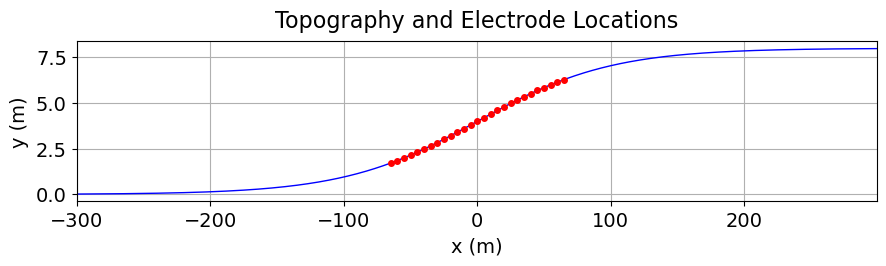

In [7]:
unique_locations = dc_data.survey.unique_electrode_locations

fig = plt.figure(figsize=(10, 2))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.plot(topo_2d[:, 0], topo_2d[:, -1], color="b", linewidth=1)
ax.plot(unique_locations[:, 0], unique_locations[:, -1], "ro", markersize=4)
ax.set_xlim([topo_2d[:, 0].min(), topo_2d[:, 0].max()])
ax.set_xlabel("x (m)", labelpad=5)
ax.set_ylabel("y (m)", labelpad=5)
ax.grid(True)
ax.set_title("Topography and Electrode Locations", fontsize=16, pad=10)
plt.show(fig)

### Plot Observed Data in Pseudo-Section

Here we use the [plot_pseudosection](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.utils.plot_pseudosection.html#SimPEG.electromagnetics.static.utils.plot_pseudosection) utility function to plot the normalized voltage data in pseudosection. We also use the [apparent_resistivity_from_voltage](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.utils.apparent_resistivity_from_voltage.html#SimPEG.electromagnetics.static.utils.apparent_resistivity_from_voltage) utility function to convert the data to apparent resistivities, which are also plotted in pseudosection.

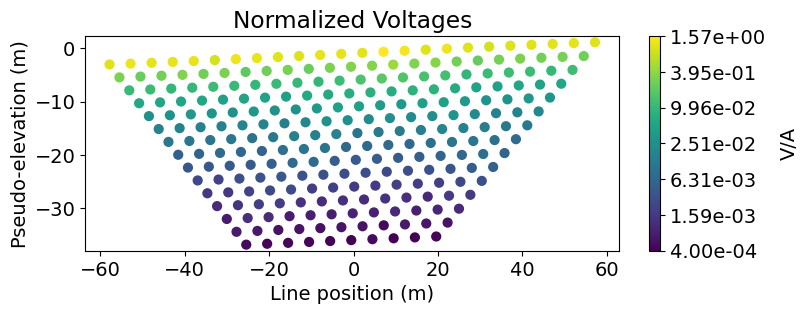

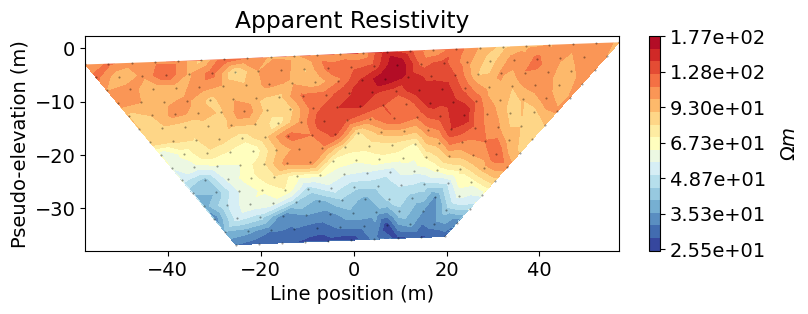

In [8]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(dc_data.survey, dc_data.dobs)

# Plot apparent resistivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data.survey,
    apparent_resistivities,
    plot_type="contourf",
    data_locations=True,
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Resistivity")
plt.show()

## Step 2: Assign Uncertainties

Field-collected data contains both the geophysical signal of interest and noise. As such, the observed datum $d_i^{obs}$ can be defined as:

$$
d_i^{obs} = d_i^{true} + \eta_i
$$

where $d_i^{true}$ is the geophysical signal we want to interpret and $\eta_i$ represents the noise. In geophysical inversion, it important that we accurately quantify the noise on our data. Because our goal is to recover a model that explains the geophysical signal of interest, and not necessarily one that fits the data perfectly.

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/true_observed_data.png" width="90%" align="center"/>

**Definition of uncertainties:** For a particular datum, the uncertainty is an estimate of the standard deviation of the noise on our data. In SimPEG, we assume the noise is uncorrelated Gaussian with zero mean. An online resource explaining uncertainties and their role in the inversion can be found [here](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/Uncertainties.html).

**Assigning uncertainties to DC resistivity data:** For both normalized voltage data and apparent resistivity data, we generally apply a percent uncertainty plus a very small floor value to all data. Differences in electrode spacing and subsurface resistivity result in measured voltages and apparent conductivities that span several orders of magnitude. A percent uncertainty ensures all data are fit equally. Depending on the quality of the data, we may choose a percent uncertainty between 2% - 10%. The floor uncertainty ensures stability when there are zero-crossings or erroneously small voltages.

### <span style="color:darkgreen">Exercise (beginner):</span>

Assign uncertainties of 1e-8 V/A + 8 % to all data. We can do this by setting the *standard_deviation* property of the data object.

### <span style="color:darkorange">Exercise (advanced):</span>

Assign uncertainties of 1e-8 V/A + 4 % to all data. This represents the case when we under-estimate the standard deviations of the noise on our data.

In [9]:
# Apply uncertainties to normalized voltage data
dc_data.standard_deviation = 1e-8 + 0.08 * np.abs(dc_data.dobs)

Below, we plot the sorted data values including uncertainty bounds.

Text(0, 0.5, 'Observed Data (V/A)')

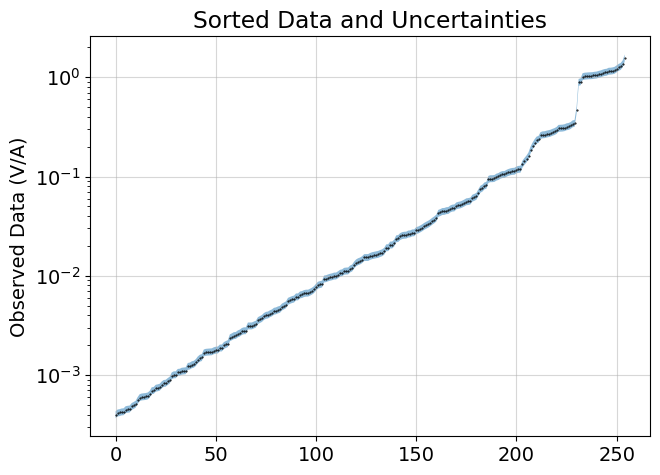

In [10]:
# Sorted DC data and their uncertainties
inds_sort = np.argsort(np.abs(dc_data.dobs))
sorted_data = np.abs(dc_data.dobs[inds_sort])
sorted_std = dc_data.standard_deviation[inds_sort]

fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

x_plot = np.arange(0, len(sorted_data))
ax.semilogy(x_plot, sorted_data, "k.", markersize=1)

ax.set_title("Sorted Data and Uncertainties")
ax.fill_between(x_plot, sorted_data - sorted_std, sorted_data + sorted_std, alpha=0.5)
ax.grid(alpha=0.5)
ax.set_ylabel("Observed Data (V/A)")

## Step 3: Designing a (Tree) Mesh

Here, we define the mesh used for the inversion. Not only will this define the numerical grid on which we solve the forward problem for a given model, it also determine the discretize spacing on which we recover the model itself. Recall our general rules for designing meshes to simulate DC resistivity data:

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/tree_mesh.png" width="45%" align="right"/>

1. Because there are no currents in the air, we do not need to pad upwards. I.e. the top of the mesh corresponds to the top of the topography.
2. We require at least 2-3 cells between each current electrode; with more accurate results being obtained when the minimum cell size is smaller. For a 2.5D problem geometry, we can discretize much finer.
3. To be safe, the padding thickness should be at least 2-3 times the largest electrode spacing. 
4. The increase in cell size at increasing distance from the current electrodes should not happen too abruptly. At each cell size, you should have a layer at least 4 cells thick before increasing the cell size.
5. Finer discretization is required when topography is significant.


### <span style="color:darkgreen">Exercise (beginner):</span>

Define and provide reasonable values for the following variables:

* **dh** (minimum cell width)
* **dom_width_x** (width of the domain along x)
* **dom_width_y** (width of the domain along y)

To do this, we access information from our data object. Here we:

1. Obtain the unique electrode locations from the *dc_data* object
2. Use this to find the minimum and maximum electrode spacing
3. Use this to determine good values for *dh*, *dom_width_x* and *dom_width_y*

In [11]:
unique_electrodes = dc_data.survey.unique_electrode_locations

In [12]:
s_min = np.min(np.diff(unique_electrodes[:, 0]))
s_max = s_min * dc_data.survey.source_list[0].vnD

In [13]:
print(s_min)
print(s_max)

5.0
[75.]


In [14]:
dh = s_min / 10.0  # base cell width
dom_width_x = 8 * s_max  # domain width x
dom_width_y = 4 * s_max  # domain width y

In [15]:
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcy = 2 ** int(np.round(np.log(dom_width_y / dh) / np.log(2.0)))  # num. base cells y

# Define the base mesh with top at z = 0 m
hx = [(dh, nbcx)]
hy = [(dh, nbcy)]
mesh = TreeMesh([hx, hy], origin="CN")

# Shift top to maximum topography and center of survey line
y_topo_max = np.max(topo_2d[:, -1])
mesh.origin = mesh.origin + np.r_[np.median(topo_2d[:, 0]), y_topo_max]

In [16]:
# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d[np.abs(topo_2d[:, 0]) < 150.0, :],
    padding_cells_by_level=[0, 0, 4, 4],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = dc_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[10, 8, 8, 8, 4, 4], finalize=False
)

In [17]:
# Finalize the mesh
mesh.finalize()

## Step 4: Define the Active Cells

Use the [active_from_xyz](https://discretize.simpeg.xyz/en/main/api/generated/discretize.utils.active_from_xyz.html) utility function to find the indices of the active cells using the mesh and surface topography. The output quantity is a ``bool`` array.

In [18]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

## Step 5: Project Survey to Discretized Topography

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/project_electrodes.png" width="30%" align="right"/>

Surface DC resistivity data will not be modeled accurately if the electrodes are modeled as living above or below the surface. It is especially problematic when electrodes are modeled as living in the air. Prior to inverting DC resistivity data, we must project the electrodes from their true elevation to the surface of the *discretized* topography. This is done using the [drape_electrodes_on_topography](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography.html#SimPEG.electromagnetics.static.resistivity.Survey.drape_electrodes_on_topography) method.

In [19]:
dc_data.survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Step 6: Mapping from the Model to the Mesh

For DC resistivity inversion, we generally define the model parameters as the log-resistivity values of all active cells. This is done for several reasons:

1. The resistivity of the inactive (air) cells is known, so we want to leave these values fixed during the inversion.
2. Electrical resistivity spans many orders of magntitude. So it is better to impose constraints on log-values because they exist on the same numerical scale.
3. Inverting to recover log-resistivity values will naturally impose a positivity constraint on subsurface electrical resistivity.

To define our model parameters this way, our mapping must first convert the model values to resistivity values on active cells, then project these values to the entire mesh AND set a static value for all air cells.

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/mapping_2.png" width="80%" align="center"/>

### <span style="color:darkgreen">Exercise (beginner):</span>

First, generate an [SimPEG.maps.ExpMap](https://docs.simpeg.xyz/content/api/generated/SimPEG.maps.ExpMap.html#SimPEG.maps.ExpMap) mapping object to map log-resistivities to resistivities. Don't forget to set the number of model parameters as equal to the number of active cells. Next, generate a [SimPEG.maps.InjectActiveCells](https://docs.simpeg.xyz/content/api/generated/SimPEG.maps.InjectActiveCells.html#SimPEG.maps.InjectActiveCells) mapping object to project values on active cells to the entire mesh. Make sure to fix the value of inactive (air) cells to 1e8 $\Omega m$. Finally, use the $*$ operator to combine the separate mapping objects into a single mapping.

In [20]:
# Model parameters to all cells
log_resistivity_map = maps.InjectActiveCells(mesh, active_cells, 1e8) * maps.ExpMap(
    nP=n_active
)

## Step 7: Define the Forward Simulation

Since our model consists of log-resistivities, we use the *rhoMap* keyword argument to set the mapping from the model to the mesh cells. Except for in extreme cases, we can compute and store the Jacobian explicitly for 2.5D problems. By doing so, we drastically reduce the run-time of the inversion.

In [21]:
dc_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=dc_data.survey, rhoMap=log_resistivity_map, storeJ=True
)

## Step 8: Starting/Reference Models

The **starting model** defines a reasonable starting point for the inversion and frequently represents an initial estimate of the true model. It should be noted that the staring model **cannot be vector of zeros,** otherwise the inversion will be unable to compute a gradient direction at the first iteration. For DC resistivity inversion, the starting model is generally a halfspace estimated from the set of apparent resistivities.

The **reference model** is used to include a-priori geological information in the recovered model. By default, the starting model is set as the reference model.

### <span style="color:darkgreen">Exercise (beginner):</span>

Generate a halfspace starting and reference model using the median apparent resistivity value. The length of the starting and reference models **must** equal the number of model parameters!!!

In [22]:
# Median apparent resistivity
median_resistivity = np.median(apparent_resistivities)

# Create staring model from log-conductivity
starting_model = np.log(median_resistivity) * np.ones(n_active)

## Step 9: Define the Inverse Problem

Geophysical inversion is frequently formulated as an optimization problem. The solution to the inverse problem is the model $\mathbf{m}$ which minimizes an objective (penalty) function $\phi (\mathbf{m})$ of the form:

$$
\min_{\mathbf{m}} \; \phi (\mathbf{m}) = \phi_d (\mathbf{m}) + \beta \, \phi_m (\mathbf{m})\\
$$

where

* $\phi_d (\mathbf{m})$ is the data misfit. It is a measure of how well data predicted with a model $\mathbf{m}$ fits the data.
* $\phi_m (\mathbf{m})$ is the regularization. It is where we impose structural constraints on the recovered model.
* $\beta$ is the trade-off parameter that balances the relative emphasis of fitting the data and imposing structure.

In step 9, SimPEG functionality is used to generate objects that define:

* the data misfit
* the regularization
* the algorithm that solves the optimization problem
* an object that connects the data misfit, regularization and optimization algorithm

In step 10, we discuss the approach for selecting an appropriate trade-off parameter $\beta$.

### Step 9a: Define the Data Misfit

The data misfit $\phi_d (\mathbf{m})$ is a measure of how well data predicted with a given model $\mathbf{m}$ fits the observed data. If the data misfit is too large, the model clearly does not explain the observed data and is therefore not a suitable model. In geophysical inversion, it is common to define the data misfit as the L2-norm of the weighted residual between the observed data and predicted data:

$$
\phi_d (\mathbf{m})
= \sum_{i=1}^{nD} \, \Bigg ( \frac{d_i^{pred} - d_i^{obs}}{\varepsilon_i} \Bigg )^2
= \big \| \mathbf{W_d} \big ( F[\mathbf{m}] - \mathbf{d^{obs}} \big ) \big \|^2
$$

We define $F[\mathbf{m}]$ as the predicted data for a given model. And $\mathbf{W_d}$ is a diagonal matrix that weights the residual by the data uncertainties. We can see from this expression that the data misfit is smaller when:

* $F[\mathbf{m}] \rightarrow \mathbf{d^{obs}}$
* The data uncertainties $\varepsilon_i$ are very large

### <span style="color:darkgreen">Exercise (beginner):</span>

Generate a [data_misfit.L2DataMisfit](https://docs.simpeg.xyz/content/api/generated/SimPEG.data_misfit.L2DataMisfit.html) object and call it **dmis**. To instantiate this objected, we must set the following keyword arguments:

* **simulation=dc_simulation** (our simulation object)
* **data=dc_data** (our data object)

In [23]:
dmis = data_misfit.L2DataMisfit(simulation=dc_simulation, data=dc_data)

### Step 9b: Regularization

The regularization function $\phi_m (\mathbf{m})$ is where we impose structural constraints on the recovered model; please visit [this online resource](https://giftoolscookbook.readthedocs.io/en/latest/content/fundamentals/ObjectiveFunction.html). In SimPEG, there are a multitude of objects that can be used to define various types of regularization. A very common regularization function for geophysical inversion is weighted least-squares:

$$
\phi_m (\mathbf{m})
= \alpha_s \, \big \| \mathbf{W_s} \big ( \mathbf{m - m}_{ref} \big ) \big \|^2
+ \alpha_x \, \big \| \mathbf{W_x \, G_x \, m} \big \|^2
+ \alpha_y \, \big \| \mathbf{W_z \, G_y \, m} \big \|^2
$$

where 

* $\alpha_s, \alpha_x, \alpha_y$ balance the relative emphasis on each term,
* $\mathbf{W}_s, \mathbf{W}_x, \mathbf{W}_y$ are matrices that apply cell weights,
* $\mathbf{G_x}$ and $\mathbf{G_y}$ are partial gradient operators,
* and $\mathbf{m}_{ref}$ is a user-defined reference model

Weighted least-squares regularization imposes constraints ensuring the inversion recovers a model that 1) differs minimally from a reference model $\mathbf{m}_{ref}$, and/or 2) has smooth gradients along the x and y directions.

### <span style="color:darkgreen">Exercise (beginner):</span>

Generate a [regularization.WeightedLeastSquares](myst:SimPEG#SimPEG.regularization.WeightedLeastSquares) object and call it **reg**. Set to invert for the smoothest model by instantiating the object with:

* **mesh** (the mesh as an input argument)
* **active_cells=active_cells** (regularization only acts on active cells)
* **reference_model=starting_model** (set starting model as the reference model)
* **alpha_s=1e-5** (set impact of the smallness term to be negligible)

### <span style="color:darkorange">Exercise (advanced):</span>

Set the regularization to enforce smoothness roughly 10x more than smallness. Do this by setting **length_scale_x** and **length_scale_y** to **10** as keyword arguments instead of setting **alpha_s**. 

In [24]:
# BEGINNER
reg = regularization.WeightedLeastSquares(
    mesh, active_cells=active_cells, reference_model=starting_model, alpha_s=1e-5
)

# ADVANCED
# reg = regularization.WeightedLeastSquares(
#     mesh,
#     active_cells=active_cells,
#     reference_model=starting_model,
#     length_scale_x=10,
#     length_scale_y=10
# )

### Step 9c: Optimization

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/newton_iteration.png" width="30%" align="right"/>

For a given trade-off parameter $\beta$, we must solve the following optimization problem:

$$
\min_{\mathbf{m}} \; \phi (\mathbf{m}) = \phi_d (\mathbf{m}) + \beta \phi_m (\mathbf{m}) \\
$$

Because our data misfit and regularization functions are parabolic, the solution $\mathbf{m^*}$ occurs when the gradient is equal to zero, i.e.:

$$
\nabla \phi(\mathbf{m^*}) = \mathbf{0}
$$

In practice, this problem is solved iteratively using quasi-Newton methods (see figure). Where $\mathbf{H}$ represents an approximation of the Hessian, a model update $\delta \mathbf{m}$ direction is obtained by solving the following linear system:

$$
\mathbf{H}_k\, \delta \mathbf{m}_k = - \nabla \! \phi_k
$$

We then determine an appropriate step length $\gamma$ and update the model as follows:

$$
\mathbf{m}_{k+1} = \mathbf{m}_k + \gamma \, \delta \mathbf{m}_k
$$

This process is repeated until stopping criteria for the algorithm is reached.


### <span style="color:darkgreen">Exercise (beginner):</span>

Generate an [optimization.InexactGaussNewton](https://docs.simpeg.xyz/content/api/generated/SimPEG.optimization.InexactGaussNewton.html) object to solve the invert problem and call it **opt**. Set the following properties for the algorithm via keyword arguments:

* **maxIter=40** (maximum number of iterations; beta and Newton)
* **maxIterLS=20** (maximum number of line searches for $\gamma$)
* **maxIterCG=20** (maximum number of conjugate gradient iterations)
* **tolCG=1e-3** (minimum relative error threshold)

In [25]:
opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=40, maxIterCG=20, tolCG=1e-3
)

### Step 9d: Inverse Problem

### <span style="color:darkgreen">Exercise (beginner):</span>

Use the [BaseInvProblem](https://docs.simpeg.xyz/content/api/generated/SimPEG.inverse_problem.BaseInvProblem.html) class to fully define the inverse problem that is solved at each beta (trade-off parameter) iteration. Use the variable name **inv_prob**. Instantiation requires the following as input arguments:

* **dmis** (the data misfit object)
* **reg** (the regularization object)
* **opt** (the optimization object)

In [26]:
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Step 10: Defining Inversion Directives

Directives provide specific instructions to the inversion while it is running. Here, we define SimPEG directives commonly used for least-squares DC resistivitiy inversion.

### 10a: Beta Cooling Directives

<img src="https://raw.githubusercontent.com/simpeg/agrogeo24/main/images/tikhonov_curve.png" width="40%" align="right"/>

In practice, we don't really know the ideal value for the trade-off parameter $\beta$ that balances the data misfit and regularization functions. As a result, we use a $\beta$ cooling approach. As shown in the figure, we start with a large value for $\beta$. We solve the optimization problem and recover a model that surely won't fit the data. We then lower $\beta$ by a constant factor and recover another model that fits the data better. We repeat this process until the data misfit for the recovered model hits a target value $\phi_d^*$. The SimPEG directives which control this process are:

- [BetaEstimate_ByEig](myst:SimPEG#SimPEG.directives.BetaEstimate_ByEig): Used to find and set a reasonable starting value for the trade-off parameter (beta).

- [BetaSchedule](myst:SimPEG#SimPEG.directives.BetaSchedule): Sets the reduction factor for beta whenever it is reduced (*coolingFactor*). And sets the number of Newton iterations (*coolingRate*) that are used to solve the optimization problem at each new beta.

- [TargetMisfit](myst:SimPEG#SimPEG.directives.TargetMisfit): Terminates the inversion when the data misfit equals the target misfit $\phi_d^*$. This set using *chifact*, when $\phi_d^* = \chi \times num.data$

**Important:** If the uncertainties perfectly characterize the standard deviations of the noise on our data, the predicted data should adequately fit the observed data when $\phi_d$ equals the number of data. However, in the event we over/under-estimate the uncertainties, it is best to examine the curve and infer the model.

### <span style="color:darkgreen">Exercise (beginner):</span>

Define the starting beta, schedule and target misfit directives.

* Generate a [directives.BetaEstimate_ByEig](myst:SimPEG#SimPEG.directives.BetaEstimate_ByEig) object and call it **starting_beta**. Set keyword argument **beta0_ratio=100**
* Generate a [directives.BetaSchedule](myst:SimPEG#SimPEG.directives.BetaSchedule) and call it **beta_schedule**. Set the following keyword arguments:

    * **coolingFactor=2** (reduction factor for $\beta$)
    * **coolingRate=2** (number of Newton iterations at each $\beta$)

* Generate a [directives.TargetMisfit](myst:SimPEG#SimPEG.directives.TargetMisfit) to set stopping criteria for the inversion and call it **target_misfit**. Set keyword argument **chifact=1** to so the inversion terminates when data misfit equals number of data.

In [27]:
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=100)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=1.0)

### Other Directives

Other common directives for weighted least-squares inversion of DC resistivity data are:

- [UpdateSensitivityWeights](myst:SimPEG#SimPEG.directives.UpdateSensitivityWeights): apply sensitivity weighting to counteract the natural tendancy of DC resistivity inversion to place materials near the electrodes. Since the problem is non-linear and the sensitivities are updated with every model, we set `every_iteration=True`.

- [UpdatePreconditioner](myst:SimPEG#SimPEG.directives.UpdatePreconditioner): Apply Jacobi preconditioner when solving the optimization problem to reduce the number of conjugate gradient iterations. We set `update_every_iteration=True` because the ideal preconditioner is model-dependent.

- **SaveInversionProgress:** a directive we defined earlier in the notebook to allow us to better Q.C. the inversion result.


In [28]:
sensitivity_weights = directives.UpdateSensitivityWeights(
    every_iteration=True, threshold_value=1e-2
)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
save_inversion = SaveInversionProgress()

The directive objects are organized in a ``list``. Upon starting the inversion or updating the recovered model at each iteration, the inversion will call each directive within the list **in order**. The order of the directives matters, and SimPEG will throw an error if directives are organized into an improper order. Some directives, like the ``BetaEstimate_ByEig`` are only used when starting the inversion. Other directives, like ``UpdatePreconditionner``, are used whenever the model is updated.

In [29]:
directives_list = [
    sensitivity_weights,
    update_jacobi,
    starting_beta,
    beta_schedule,
    save_inversion,
    target_misfit,
]

## Step 10: Define and Run the Inversion

### <span style="color:darkgreen">Exercise (beginner):</span>

1. Define the inversion by instantiating an [inversion.BaseInversion](https://docs.simpeg.xyz/content/api/generated/SimPEG.inversion.BaseInversion.html) object. Call this object **inv**. This object requires the **inv_prob** and **directives_list** as input arguments.
2. Use the **run** method to run the inversion. This method requires the **starting_model** as in input argument.

In [30]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run the inversion
recovered_model = inv.run(starting_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.67e+04  1.09e+04  0.00e+00  1.09e+04    1.28e+03      0              
   1  1.67e+04  1.16e+03  2.26e-02  1.54e+03    2.06e+02      0              
   2  8.36e+03  3.83e+02  3.21e-02  6.51e+02    4.67e+01      0   Skip BFGS  
   3  8.36e+03  2.58e+02  3.71e-02  5.69e+02    1.82e+01      0   Skip BFGS  
   4  4.18e+03  2.65e+02  3.57e-02  4.14e+02    1.78e+01      0              
   5  4.18e+03  1.92e+02  4.87e-02  3.96e+02    6.09e+00      0              
   6  2.09e+03  1.98e+02  4.69e-02 

## Step 11: Inversion Outputs

### 11a: Extract Some Inversion Outputs

In [31]:
iteration = save_inversion.inversion_results["iteration"]
beta = save_inversion.inversion_results["beta"]
phi_d = save_inversion.inversion_results["phi_d"]
phi_m = save_inversion.inversion_results["phi_m"]
dpred = save_inversion.inversion_results["dpred"]
models = save_inversion.inversion_results["model"]

### 11b: Plot Tikhonov Curve

Plot the Tikhonov curve to determine whether the inversion reaches target misfit, and the point at which the recovered models start to overfit the data.

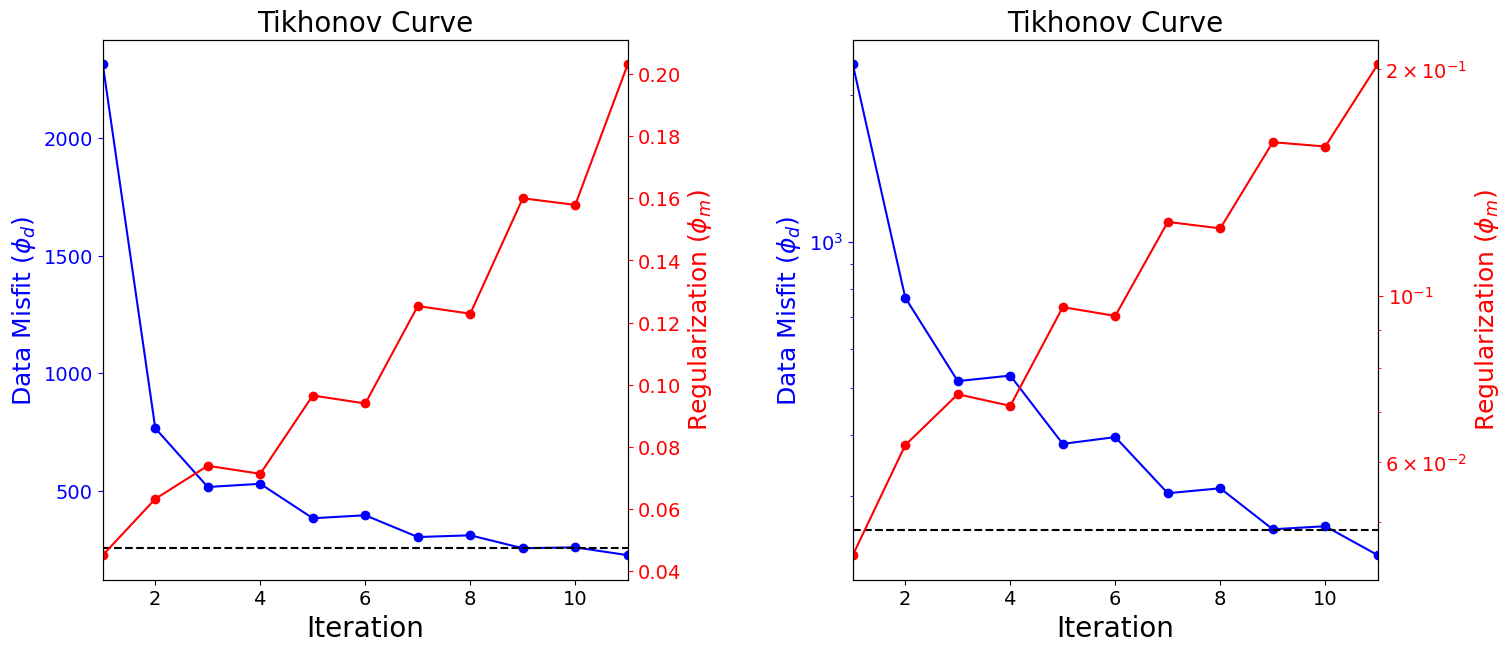

In [32]:
fig = plt.figure(figsize=(15, 6))
ax1a = fig.add_axes([0.05, 0.05, 0.35, 0.9])
ax1b = ax1a.twinx()
ax2a = fig.add_axes([0.55, 0.05, 0.35, 0.9])
ax2b = ax2a.twinx()

ax1a.plot(iteration, phi_d, "b-o")
ax1a.plot(
    iteration,
    target_misfit.chifact * dc_data.survey.nD * np.ones_like(iteration),
    "k--",
)
ax1b.plot(iteration, phi_m, "r-o")

ax1a.set_xlabel("Iteration", fontsize=20)
ax1a.set_ylabel("Data Misfit ($\phi_d$)", color="b", fontsize=18)
ax1a.tick_params(axis="y", colors="b")
ax1a.set_title("Tikhonov Curve", fontsize=20)
ax1a.set_xlim([np.min(iteration), np.max(iteration)])
ax1b.tick_params(axis="y", colors="r")
ax1b.set_ylabel("Regularization ($\phi_m$)", color="r", fontsize=18)

ax2a.semilogy(iteration, phi_d, "b-o")
ax2a.semilogy(
    iteration,
    target_misfit.chifact * dc_data.survey.nD * np.ones_like(iteration),
    "k--",
)
ax2b.semilogy(iteration, phi_m, "r-o")
ax2a.set_xlabel("Iteration", fontsize=20)
ax2a.set_ylabel("Data Misfit ($\phi_d$)", color="b", fontsize=18)
ax2a.tick_params(axis="y", which="both", colors="b")
ax2a.set_title("Tikhonov Curve", fontsize=20)
ax2a.set_xlim([np.min(iteration), np.max(iteration)])
ax2b.tick_params(axis="y", which="both", colors="r")
ax2b.set_ylabel("Regularization ($\phi_m$)", color="r", fontsize=18)

plt.show()

### 11c: Choose an Iteration to Further Examine

In [33]:
model_iteration = -1  # -1 for final model

### 11d: Plot Observed Data, Prediced Data and Normalized Misfit

This step is necessary for determining whether the recovered model accurately reproduces observed anomalies. Here, we plot the observed data, predicted data for the recovered model, and the normalized data misfit. As we can see, the recovered model reproduces the observed data quite well. And the normalized misfit map indicates we are not overfitting certain electrodes relative to others.

If desired, one could also use the [apparent_resistivity_from_voltage](https://docs.simpeg.xyz/content/api/generated/SimPEG.electromagnetics.static.utils.apparent_resistivity_from_voltage.html#SimPEG.electromagnetics.static.utils.apparent_resistivity_from_voltage) utility function compare observed and predicted data as apparent resistivities.

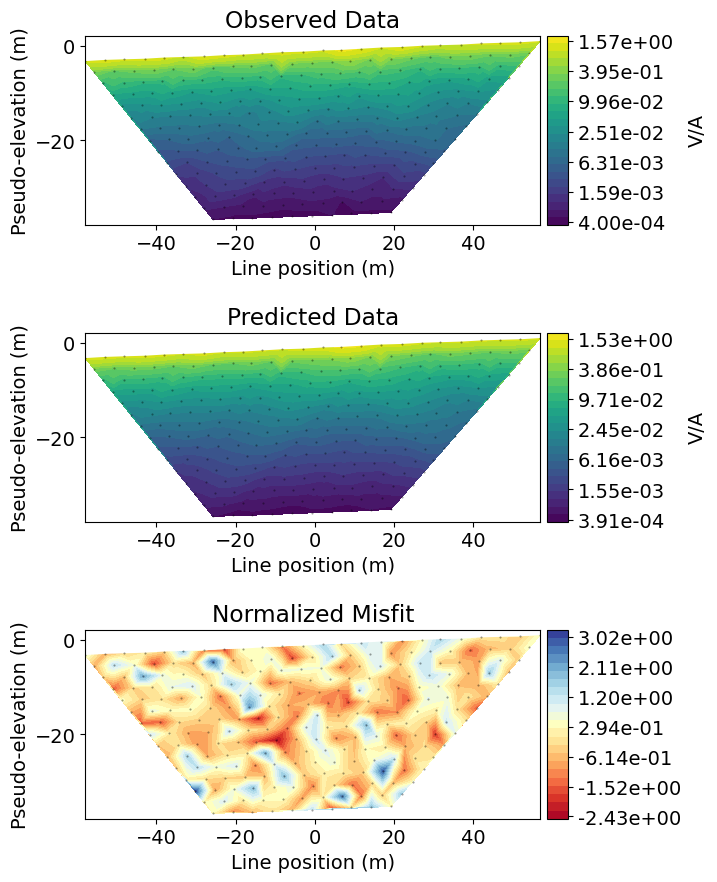

In [34]:
dobs = dc_data.dobs
std = dc_data.standard_deviation

fig = plt.figure(figsize=(7, 9))
data_array = [
    np.abs(dobs),
    np.abs(dpred[model_iteration]),
    (dobs - dpred[model_iteration]) / std,
]
plot_title = ["Observed Data", "Predicted Data", "Normalized Misfit"]
plot_units = ["V/A", "V/A", ""]
scale = ["log", "log", "linear"]
cmap_list = [mpl.cm.viridis, mpl.cm.viridis, mpl.cm.RdYlBu]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        dc_data.survey,
        data_array[ii],
        "contourf",
        data_locations=True,
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": cmap_list[ii]},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

### 11e: Plot Observed and Predicted Apparent Resistivities

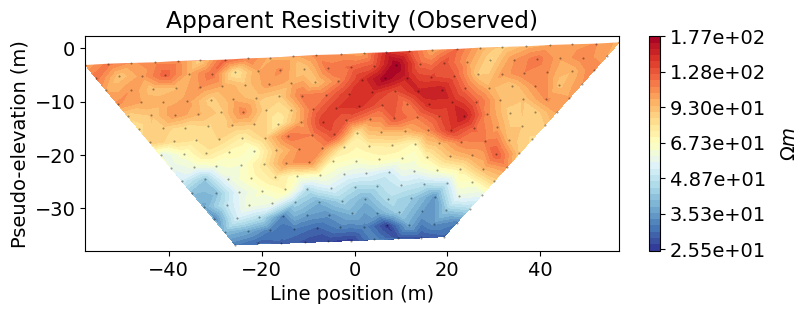

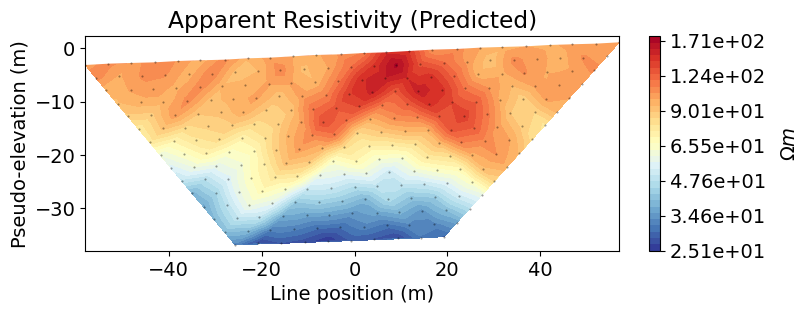

In [35]:
# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data.survey,
    dobs=apparent_resistivities,
    plot_type="contourf",
    data_locations=True,
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 40, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Resistivity (Observed)")
plt.show()

# Plot apparent conductivity pseudo-section
apparent_resistivities_dpred = apparent_resistivity_from_voltage(
    dc_data.survey, dpred[model_iteration]
)

fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data.survey,
    dobs=apparent_resistivities_dpred,
    plot_type="contourf",
    data_locations=True,
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 40, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_title("Apparent Resistivity (Predicted)")
plt.show()

### 11f: Plot Recovered Model

As we can see, weighted least-squares regularization leads to the recovery of smooth models.

In [36]:
air_resistivity = 1e8
background_resistivity = 1e2
block_resistivity = 1e3
basement_resistivity = 1e1

In [37]:
# Define resistivity model
true_resistivity = background_resistivity * np.ones(mesh.n_cells)

ind_basement = mesh.cell_centers[:, -1] < -16.0
true_resistivity[ind_basement] = basement_resistivity

ind_block = model_builder.get_indices_block(
    np.r_[5.0, -10.0], np.r_[15.0, 0.0], mesh.cell_centers
)
true_resistivity[ind_block] = block_resistivity

true_resistivity = true_resistivity[active_cells]

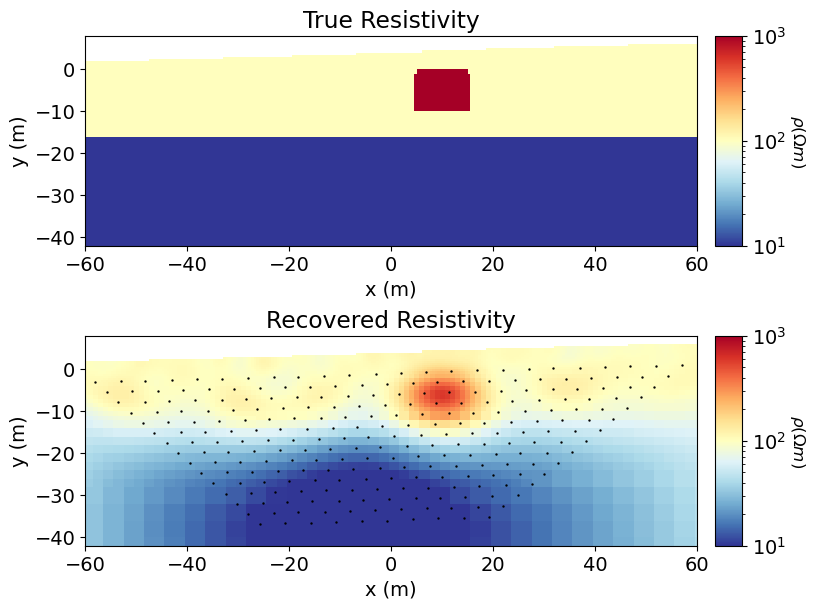

In [38]:
# Spatial plotting limits
x_lim = [-60, 60]
y_lim = [y_topo_max - 50, y_topo_max]

# Define a mapping to plot models and ignore inactive cells
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)
plotting_model = [true_resistivity, np.exp(models[model_iteration])]
norm = LogNorm(vmin=1e1, vmax=1e3)

fig = plt.figure(figsize=(9, 6))
ax1 = 2 * [None]
ax2 = 2 * [None]
title_str = [
    "True Resistivity",
    "Recovered Resistivity",
]

for ii in range(0, 2):
    ax1[ii] = fig.add_axes([0.14, 0.55 - 0.5 * ii, 0.68, 0.35])
    mesh.plot_image(
        plotting_map * plotting_model[ii],
        ax=ax1[ii],
        grid=False,
        pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
    )

    ax1[ii].set_xlim(x_lim)
    ax1[ii].set_ylim(y_lim)
    ax1[ii].set_title(title_str[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.84, 0.55 - 0.5 * ii, 0.03, 0.35])
    cbar = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
    )
    cbar.set_label(r"$\rho (\Omega m)$", rotation=270, labelpad=15, size=12)

pseudo_locations_xy = pseudo_locations(dc_data.survey)
ax1[1].scatter(pseudo_locations_xy[:, 0], pseudo_locations_xy[:, -1], 0.5, "k")

plt.show()